Is the graph strongly connected? True
Is the graph aperiodic? True
pi_bar = [0.23058252 0.16504854 0.27669903 0.18203883 0.14563107]


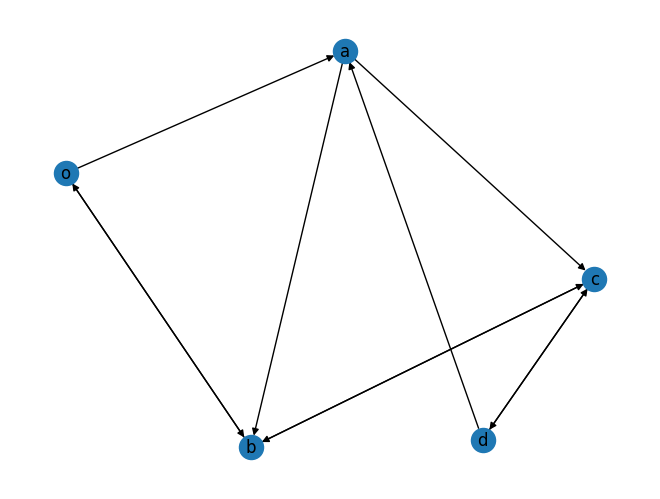

In [74]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

TRM = np.array([
    [0, 2/5, 1/5, 0, 0],
    [0, 0, 3/4, 1/4, 0],
    [1/2, 0, 0, 1/3, 0],
    [0, 0, 1/3, 0, 2/3],
    [0, 1/2, 0, 1/3, 0]
])

# Compute relevant parameters
w = TRM @ np.full(5, 1, dtype=int)
w_star = np.max(w)
P = np.linalg.inv(np.diag(w)) @ TRM
P_bar = TRM/w_star 
P_bar = P_bar + np.diag(np.ones(len(w))-np.sum(P_bar,axis=1))

# Create networkx graph
G = nx.from_numpy_array(TRM, create_using=nx.DiGraph)
mapping = {0:"o", 1:'a', 2:'b', 3:'c', 4:'d'}
nx.relabel_nodes(G, mapping, copy=False)
nx.draw(G, with_labels=True)

print('Is the graph strongly connected?', nx.is_strongly_connected(G))
print('Is the graph aperiodic?', nx.is_aperiodic(G))

# Aperiodic, strongly connected => P_bar's rows converge to pi_bar:
pi_bar = np.linalg.matrix_power(P_bar, 1500)[0]
print('pi_bar =', pi_bar)

In [75]:
# a (global poisson clock):
N = 100
rate = N*w_star
t = 0
tot = 0

# rt stores the return time of each particle, initialized at -1
rt = np.full(N, -1, dtype=float)
# pos stores the position of each particle at any given time
pos = np.full(N, 1, dtype=int)
# left stores whether each particle left node a to avoid assigning a return time 
# even if the particle never left
left = np.full(N, False, dtype=bool)

while -1 in rt:
    t_move = -np.log(np.random.rand()) / rate
    t += t_move
    particle = np.random.randint(N)
    pos[particle] = np.random.choice(5, p=P_bar[pos[particle],:])

    if pos[particle] == 1 and left[particle] and rt[particle] == -1:
        rt[particle] = t

    if pos[particle] != 1 and not left[particle]:
        left[particle] = True

print('Average return time:', np.mean(rt))

Average return time: 6.077794448695279


Perfectly compatible with previous exercise, if N increases we can see the values match (independent events => doing them together or separately is the same)

In [72]:
# b:
T_FIN = 60
N = 100
# particles' rows store the amount of particles in each node at any given time
particles = np.array([[0, N, 0, 0, 0]])
# t contains the time corresponding to each row of particles
t = np.array([0], dtype=float)
rate = N*w_star

while t[-1] < T_FIN:
    # simulate global poisson clock
    t_move = -np.log(np.random.rand()) / rate
    #add row to t
    t = np.append(t, t[-1]+t_move)

    # randomly select node to move particle from according to their distribution
    node = np.random.choice(5, p=particles[-1]/N)
    # randomly select node to jump to according to P_bar
    next_node = np.random.choice(5, p=P_bar[node,:])

    # add row to particles
    particles = np.vstack((particles, particles[-1,:]))
    particles[-1][node] -= 1
    particles[-1][next_node] += 1


In [68]:
# Run again without saving all states to be able to increase T_FIN a lot

T_FIN = 1e4
N = 100
# particles' rows store the amount of particles in each node at any given time
particles = np.array([0, N, 0, 0, 0])
# total particles through each node to average
tot_part = np.array([0, N, 0, 0, 0])
# t = time
t = 0
i = 0
rate = N*w_star

while t < T_FIN:
    # simulate global poisson clock
    t_move = -np.log(np.random.rand()) / rate
    #increase t
    t += t_move
    # randomly select node to move particle from according to their distribution
    node = np.random.choice(5, p=particles/N)
    # randomly select node to jump to according to P_bar
    next_node = np.random.choice(5, p=P_bar[node,:])

    # move particle
    particles[node] -= 1
    particles[next_node] += 1

    tot_part += particles
    i += 1

avg = tot_part/(N * i)
print('avg:', avg)
print('pi_bar:', pi_bar)
print('difference:', np.abs(avg-pi_bar))

avg: [0.22982586 0.16507761 0.27753189 0.18221592 0.14534972]
pi_bar: [0.23058252 0.16504854 0.27669903 0.18203883 0.14563107]
difference: [7.56666889e-04 2.90636730e-05 8.32861672e-04 1.77089089e-04
 2.81347128e-04]


Result with T_FIN = 1e5:

avg: [0.23099533 0.16496352 0.27656043 0.18187879 0.14560203]

pi_bar: [0.23058252 0.16504854 0.27669903 0.18203883 0.14563107]

difference: [4.12807968e-04 8.50258695e-05 1.38599461e-04 1.60048157e-04 2.90345157e-05]

In [71]:
nodes = ['o', 'a', 'b', 'c', 'd']
avgs = np.empty(5)
for i in range(5):
    avgs[i] = np.mean(particles[:,i])

print('averages:', avgs)
print('weighted averages:', avgs/N)
print(pi_bar)

averages: [23.06704188 17.27660983 26.71660321 18.73497765 14.20476742]
weighted averages: [0.23067042 0.1727661  0.26716603 0.18734978 0.14204767]
[0.23058252 0.16504854 0.27669903 0.18203883 0.14563107]


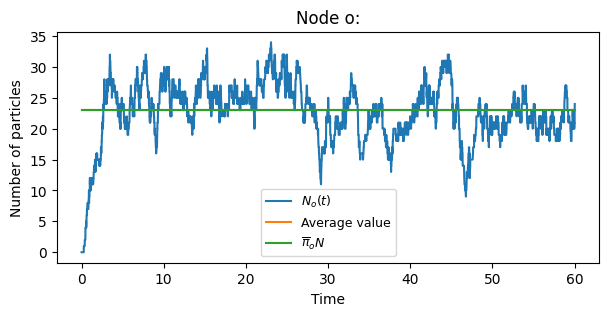

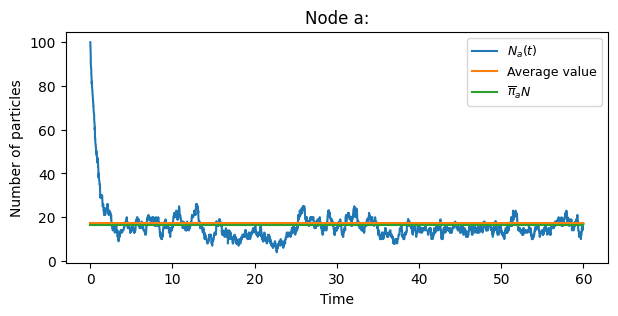

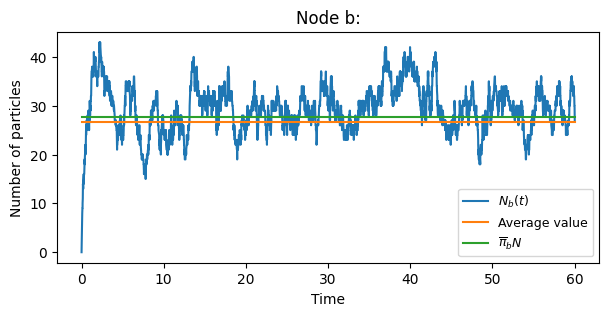

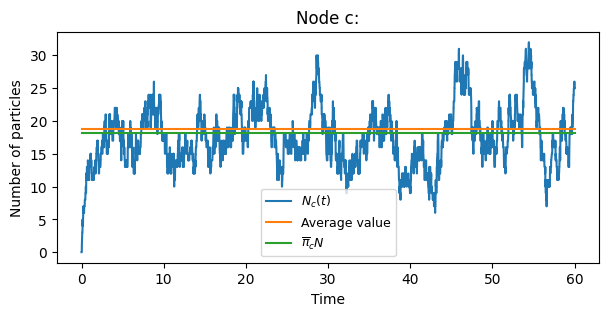

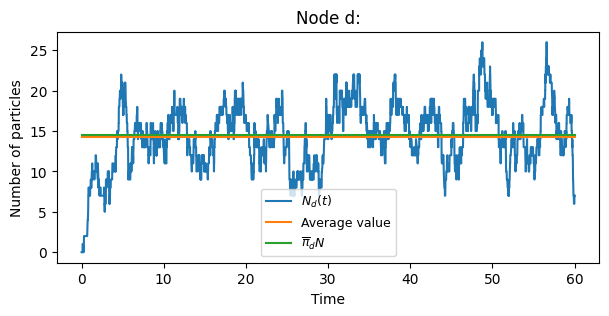

In [73]:
# Plots
for i in range(5):
    f = plt.figure(figsize=(7, 3))
    plt.plot(t, particles[:,i])
    plt.plot([0, T_FIN], [avgs[i], avgs[i]])
    plt.plot([0, T_FIN], [pi_bar[i]*N, pi_bar[i]*N])
    plt.title('Node %(n)c:'%{'n':nodes[i]})
    plt.xlabel('Time')
    plt.ylabel('Number of particles')
    plt.legend(["$N_%(n)c(t)$"%{'n':nodes[i]}, 'Average value', "$\overline{\pi}_%(n)c N$"%{'n':nodes[i]}], prop={'size':9})